In [1]:
# Cell 1: Setup, Imports, and Helper Functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import os
import sys

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Add the project root to the Python path to allow imports from src
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import config
import pandas_datareader.data as web

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported and configuration loaded.")


def get_risk_free_rate(start_date, end_date):
    """Fetches the 3-Month Treasury Bill Rate from FRED as the risk-free rate."""
    try:
        rf = web.DataReader('DTB3', 'fred', start_date, end_date)
        rf = rf.ffill() / 100 / 360
        return rf
    except Exception as e:
        return pd.Series(0, index=pd.date_range(start=start_date, end=end_date), name='DTB3')

Libraries imported and configuration loaded.


/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Cell 2: (Part 1) Load and Prepare Data

print("--- PART 1: ANALYSIS WITH ORIGINAL 3 FACTORS ---")
print("\nLoading data...")

try:
    features_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    print("Original 3-factor dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")

# Prepare data for regression
full_df_orig = index_df.join(features_df, how='inner')
full_df_orig['pca_return'] = np.log(full_df_orig['Value']).diff()
rf_rate = get_risk_free_rate(full_df_orig.index.min(), full_df_orig.index.max())
full_df_orig['rf_rate'] = rf_rate['DTB3'].reindex(full_df_orig.index, method='ffill').fillna(0)
full_df_orig['pca_excess_return'] = full_df_orig['pca_return'] - full_df_orig['rf_rate']
full_df_orig.dropna(inplace=True)

# Define X, y and the CV strategy
X_orig = full_df_orig[['MKT', 'SMB', 'WML']]
y_orig = full_df_orig['pca_excess_return']
tscv = TimeSeriesSplit(n_splits=5)

# Scale features for relevant models
scaler_orig = StandardScaler()
X_orig_scaled = scaler_orig.fit_transform(X_orig)

print("Data for Part 1 is prepared.")

--- PART 1: ANALYSIS WITH ORIGINAL 3 FACTORS ---

Loading data...
Original 3-factor dataset loaded successfully.
Data for Part 1 is prepared.


In [3]:
# Cell 3: (Part 1) Train All Models

print("Training all 5 models on the original 3-factor dataset...")

# 1. Statsmodels OLS (for p-values)
X_sm_orig = sm.add_constant(X_orig)
sm_results_orig = sm.OLS(y_orig, X_sm_orig).fit()

# 2. RidgeCV
ridge_cv_orig = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=tscv).fit(X_orig_scaled, y_orig)

# 3. LassoCV
lasso_cv_orig = LassoCV(alphas=np.logspace(-6, 2, 100), cv=tscv, random_state=42).fit(X_orig_scaled, y_orig)

# 4. Random Forest
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
rf_grid_orig = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_orig, y_orig)
best_rf_orig = rf_grid_orig.best_estimator_

# 5. XGBoost
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}
xgb_grid_orig = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), xgb_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_orig, y_orig)
best_xgb_orig = xgb_grid_orig.best_estimator_

print("All models for Part 1 have been trained.")

Training all 5 models on the original 3-factor dataset...
All models for Part 1 have been trained.


In [4]:
# Cell 4: (Part 1) Display Results

print("--- RESULTS FOR ORIGINAL 3-FACTOR MODELS ---")

# --- 1. Coefficients for Linear Models ---
# Note: OLS coeffs are from unscaled data for direct interpretation.
# Ridge/Lasso coeffs are from scaled data, showing shrinkage.
coeffs_df = pd.DataFrame({
    'OLS Coefficient': sm_results_orig.params,
    'P-Value': sm_results_orig.pvalues
}).rename(index={'const': 'Intercept'})

# Add scaled coefficients for Ridge and Lasso
coeffs_df['Ridge Coefficient (Scaled)'] = pd.Series(ridge_cv_orig.coef_, index=X_orig.columns)
coeffs_df['Lasso Coefficient (Scaled)'] = pd.Series(lasso_cv_orig.coef_, index=X_orig.columns)
coeffs_df.fillna('-', inplace=True)

print("\n--- Linear Model Coefficients & P-Values ---")
display(coeffs_df)


# --- 2. Feature Importances for Tree-Based Models ---
# For these models, "importance" is the equivalent of a coefficient's magnitude.
importances_df = pd.DataFrame({
    'Random Forest Importance': best_rf_orig.feature_importances_,
    'XGBoost Importance': best_xgb_orig.feature_importances_
}, index=X_orig.columns).sort_values(by='XGBoost Importance', ascending=False)

print("\n--- Tree-Based Model Feature Importances ---")
display(importances_df)


# --- 3. Model Performance Comparison ---
results_data = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Out-of-Sample R-squared': [
        sm_results_orig.rsquared_adj,
        r2_score(y_orig, ridge_cv_orig.predict(X_orig_scaled)),
        r2_score(y_orig, lasso_cv_orig.predict(X_orig_scaled)),
        rf_grid_orig.best_score_,
        xgb_grid_orig.best_score_
    ]
}
results_df_orig = pd.DataFrame(results_data)
print("\n--- Overall Model Performance on 3 Factors ---")
display(results_df_orig)

--- RESULTS FOR ORIGINAL 3-FACTOR MODELS ---

--- Linear Model Coefficients & P-Values ---


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_10246/1673563601.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  coeffs_df.fillna('-', inplace=True)


,OLS Coefficient,P-Value,Ridge Coefficient (Scaled),Lasso Coefficient (Scaled)
Intercept,0.002006,2.752700e-02,-,-
MKT,0.664125,3.388248e-63,0.021778,0.021638
SMB,-0.005266,8.832264e-01,-0.000171,-0.0
WML,0.068173,1.688487e-01,0.001523,0.00092



--- Tree-Based Model Feature Importances ---


,Random Forest Importance,XGBoost Importance
MKT,0.883378,0.834710
WML,0.070661,0.091718
SMB,0.045961,0.073571



--- Overall Model Performance on 3 Factors ---


,Model,Out-of-Sample R-squared
0,OLS,0.713078
1,Ridge,0.715935
2,Lasso,0.715168
3,Random Forest,0.565759
4,XGBoost,0.500157


In [5]:
# Cell 5: (Part 2) Load and Prepare Data

print("\n\n--- PART 2: ANALYSIS WITH ENGINEERED FEATURES ---")
print("\nLoading data...")

try:
    features_df_eng = pd.read_csv(config.PROCESSED_DATA_DIR / 'engineered_features.csv', index_col='Date', parse_dates=True)
    index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    print("Engineered features dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run feature_engineering.py first. Missing: {e.filename}")

# Prepare data for regression
full_df_eng = index_df.join(features_df_eng, how='inner')
full_df_eng['pca_return'] = np.log(full_df_eng['Value']).diff()
rf_rate = get_risk_free_rate(full_df_eng.index.min(), full_df_eng.index.max())
full_df_eng['rf_rate'] = rf_rate['DTB3'].reindex(full_df_eng.index, method='ffill').fillna(0)
full_df_eng['pca_excess_return'] = full_df_eng['pca_return'] - full_df_eng['rf_rate']
full_df_eng.dropna(inplace=True)

# Define X and y with engineered features
X_eng = full_df_eng.drop(columns=['Value', 'pca_return', 'rf_rate', 'pca_excess_return'])
y_eng = full_df_eng['pca_excess_return']
scaler_eng = StandardScaler()
X_eng_scaled = scaler_eng.fit_transform(X_eng)

print("Data for Part 2 is prepared.")



--- PART 2: ANALYSIS WITH ENGINEERED FEATURES ---

Loading data...
Engineered features dataset loaded successfully.
Data for Part 2 is prepared.


In [6]:
# Cell 6: (Part 2) Train All Models

print("Training all 5 models on the engineered feature dataset...")
# (Using the same models and grids, but with the new X_eng and y_eng data)

# 1. Statsmodels OLS
X_sm_eng = sm.add_constant(X_eng)
sm_results_eng = sm.OLS(y_eng, X_sm_eng).fit()

# 2. RidgeCV
ridge_cv_eng = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=tscv).fit(X_eng_scaled, y_eng)

# 3. LassoCV
lasso_cv_eng = LassoCV(alphas=np.logspace(-6, 2, 100), cv=tscv, random_state=42).fit(X_eng_scaled, y_eng)

# 4. Random Forest
# Using the same grid search setup
rf_grid_eng = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_eng, y_eng)
best_rf_eng = rf_grid_eng.best_estimator_

# 5. XGBoost
# Using the same grid search setup
xgb_grid_eng = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), xgb_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_eng, y_eng)
best_xgb_eng = xgb_grid_eng.best_estimator_

print("All models for Part 2 have been trained.")

Training all 5 models on the engineered feature dataset...
All models for Part 2 have been trained.


--- RESULTS FOR ENGINEERED FEATURE MODELS ---

--- Model Performance on Engineered Features ---


,Model,Out-of-Sample R-squared
0,OLS,0.704509
1,Ridge,0.719039
2,Lasso,0.701522
3,Random Forest,0.558755
4,XGBoost,0.487906



--- Feature Importance from Best Performing Model (XGBoost) ---
Top 15 Most Important Features:


MKT                 0.266875
SMB_roll_std_30D    0.077962
WML_roll_avg_30D    0.046065
SMB_roll_avg_7D     0.042135
WML_roll_std_7D     0.039364
SMB_lag_4           0.034184
WML_roll_std_30D    0.033437
WML_roll_avg_7D     0.033114
MKT_lag_1           0.031759
MKT_lag_2           0.030390
SMB_lag_1           0.028737
MKT_roll_std_7D     0.024851
WML_lag_4           0.023616
WML_lag_1           0.021776
MKT_roll_std_30D    0.021306
dtype: float32

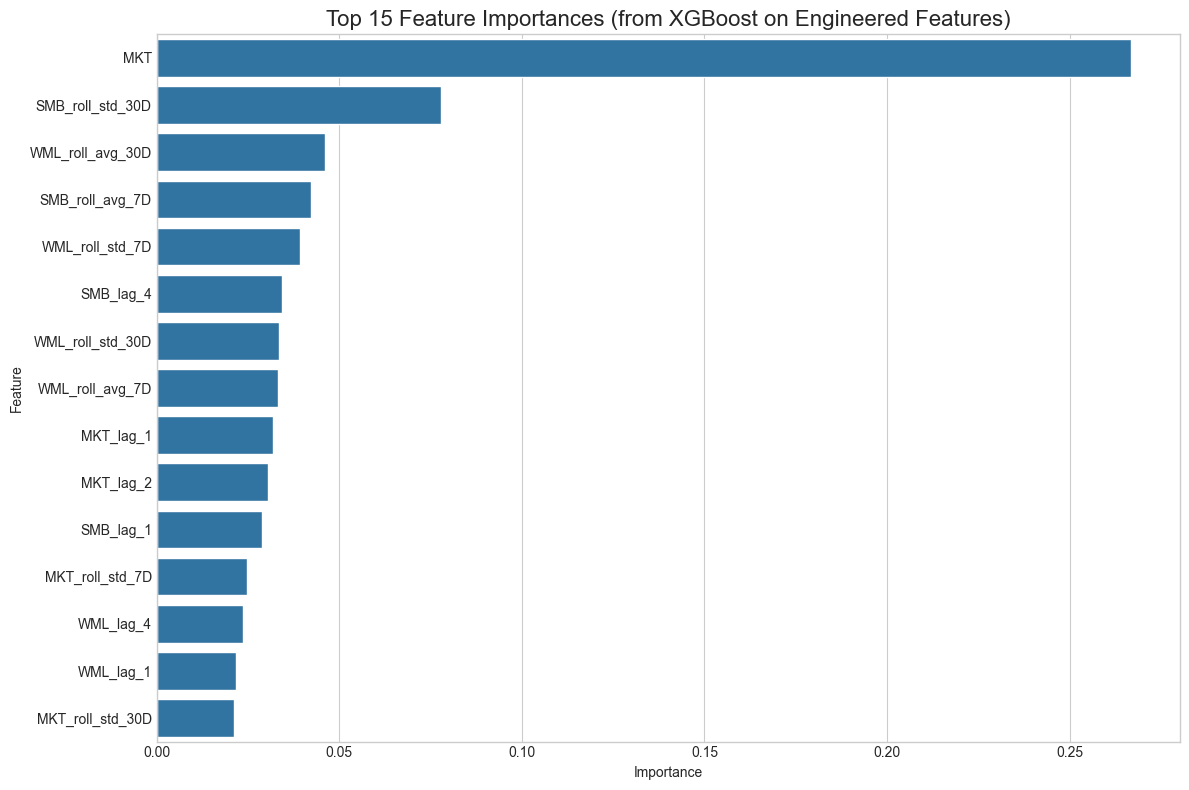

In [7]:
# Cell 7: (Part 2) Display Results and Feature Importance

print("--- RESULTS FOR ENGINEERED FEATURE MODELS ---")

# --- Model Performance Comparison ---
results_data_eng = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Out-of-Sample R-squared': [
        sm_results_eng.rsquared_adj,
        r2_score(y_eng, ridge_cv_eng.predict(X_eng_scaled)),
        r2_score(y_eng, lasso_cv_eng.predict(X_eng_scaled)),
        rf_grid_eng.best_score_,
        xgb_grid_eng.best_score_
    ]
}
results_df_eng = pd.DataFrame(results_data_eng)
print("\n--- Model Performance on Engineered Features ---")
display(results_df_eng)

# --- Feature Importance Analysis ---
print("\n--- Feature Importance from Best Performing Model (XGBoost) ---")
feature_importances = pd.Series(best_xgb_eng.feature_importances_, index=X_eng.columns).sort_values(ascending=False)

# Display & Plot Top 15 Features
print("Top 15 Most Important Features:")
display(feature_importances.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances.head(15).values, y=feature_importances.head(15).index)
plt.title('Top 15 Feature Importances (from XGBoost on Engineered Features)', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [8]:
# Cell 8: (Part 2) Display Results

print("--- RESULTS FOR ENGINEERED FEATURE MODELS ---")

# --- 1. Coefficients for Linear Models ---
# Note: This will be a much larger table
coeffs_df_eng = pd.DataFrame({
    'OLS Coefficient': sm_results_eng.params,
    'P-Value': sm_results_eng.pvalues
}).rename(index={'const': 'Intercept'})

# Add scaled coefficients for Ridge and Lasso
coeffs_df_eng['Ridge Coefficient (Scaled)'] = pd.Series(ridge_cv_eng.coef_, index=X_eng.columns)
coeffs_df_eng['Lasso Coefficient (Scaled)'] = pd.Series(lasso_cv_eng.coef_, index=X_eng.columns)
coeffs_df_eng.fillna('-', inplace=True)

print("\n--- Linear Model Coefficients & P-Values (Top 10 by OLS Coeff Magnitude) ---")
# Display top 10 most influential features according to OLS
top_10_ols = coeffs_df_eng.reindex(coeffs_df_eng['OLS Coefficient'].abs().sort_values(ascending=False).index).head(11)
display(top_10_ols)
print("Note: Lasso may have set many of these coefficients to zero, indicating feature selection.")


# --- 2. Feature Importances for Tree-Based Models ---
importances_df_eng = pd.DataFrame({
    'Random Forest Importance': best_rf_eng.feature_importances_,
    'XGBoost Importance': best_xgb_eng.feature_importances_
}, index=X_eng.columns).sort_values(by='XGBoost Importance', ascending=False)

print("\n--- Tree-Based Model Feature Importances (Top 15) ---")
display(importances_df_eng.head(15))

# --- 3. Model Performance Comparison ---
results_data_eng = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Out-of-Sample R-squared': [
        sm_results_eng.rsquared_adj,
        r2_score(y_eng, ridge_cv_eng.predict(X_eng_scaled)),
        r2_score(y_eng, lasso_cv_eng.predict(X_eng_scaled)),
        rf_grid_eng.best_score_,
        xgb_grid_eng.best_score_
    ]
}
results_df_eng = pd.DataFrame(results_data_eng)
print("\n--- Overall Model Performance on Engineered Features ---")
display(results_df_eng)

--- RESULTS FOR ENGINEERED FEATURE MODELS ---

--- Linear Model Coefficients & P-Values (Top 10 by OLS Coeff Magnitude) ---


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_10246/1266678734.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  coeffs_df_eng.fillna('-', inplace=True)


,OLS Coefficient,P-Value,Ridge Coefficient (Scaled),Lasso Coefficient (Scaled)
WML_roll_avg_30D,0.721303,1.330471e-01,0.001115,0.0
MKT,0.672514,7.520730e-35,0.017605,0.020707
MKT_roll_avg_30D,-0.553580,8.064262e-02,-0.001146,0.0
SMB_roll_avg_7D,-0.476680,1.217396e-01,-0.001582,-0.0
WML_roll_std_7D,-0.244777,2.213028e-01,-0.000557,-0.0
SMB_roll_std_30D,-0.171714,6.152548e-01,-0.001216,-0.0
MKT_roll_std_7D,0.139863,2.894965e-01,0.000498,-0.0
WML_roll_std_30D,0.132600,6.412287e-01,0.000089,-0.0
MKT_roll_std_30D,-0.123718,7.245403e-01,-0.000363,-0.0
SMB_lag_5,0.070120,1.856388e-01,0.00092,0.0


Note: Lasso may have set many of these coefficients to zero, indicating feature selection.

--- Tree-Based Model Feature Importances (Top 15) ---


,Random Forest Importance,XGBoost Importance
MKT,0.724693,0.266875
SMB_roll_std_30D,0.014449,0.077962
WML_roll_avg_30D,0.006575,0.046065
SMB_roll_avg_7D,0.009894,0.042135
WML_roll_std_7D,0.011381,0.039364
SMB_lag_4,0.007187,0.034184
WML_roll_std_30D,0.004043,0.033437
WML_roll_avg_7D,0.009601,0.033114
MKT_lag_1,0.009022,0.031759
MKT_lag_2,0.008456,0.030390



--- Overall Model Performance on Engineered Features ---


,Model,Out-of-Sample R-squared
0,OLS,0.704509
1,Ridge,0.719039
2,Lasso,0.701522
3,Random Forest,0.558755
4,XGBoost,0.487906


In [9]:
# Cell 8: (Part 3) Prepare Data for ARIMAX

print("\n\n--- PART 3: TIME-SERIES FORECASTING WITH ARIMAX ---")
print("\nLoading data for ARIMAX model...")

try:
    features_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")

# Join the datasets to align them perfectly
arimax_df = index_df.join(features_df, how='inner')
arimax_df.dropna(inplace=True)

# Define our endogenous (target) variable 'y' and exogenous (external) factors 'X'
# For ARIMAX, we predict the actual index VALUE, not the returns.
y_arimax = arimax_df['Value']
X_arimax = arimax_df[['MKT', 'SMB', 'WML']]

# We must add a constant to the exogenous variables for the model to estimate an intercept
X_arimax_const = sm.add_constant(X_arimax)

print("Data for ARIMAX prepared.")
display(arimax_df.head())



--- PART 3: TIME-SERIES FORECASTING WITH ARIMAX ---

Loading data for ARIMAX model...
Data loaded successfully.
Data for ARIMAX prepared.


,Value,MKT,SMB,WML
Date,,,,
2024-08-31,923.653726,-0.005093,-0.007866,-0.009217
2024-09-01,920.143603,-0.011407,0.006754,-0.010847
2024-09-02,894.363158,-0.034723,0.013046,-0.019596
2024-09-03,924.276311,0.033861,-0.020780,0.022369
2024-09-04,897.883226,-0.038033,0.002201,-0.021470


ADF Statistic: -1.8366
p-value: 0.3624
Conclusion: The series is non-stationary (d=1 is likely needed).


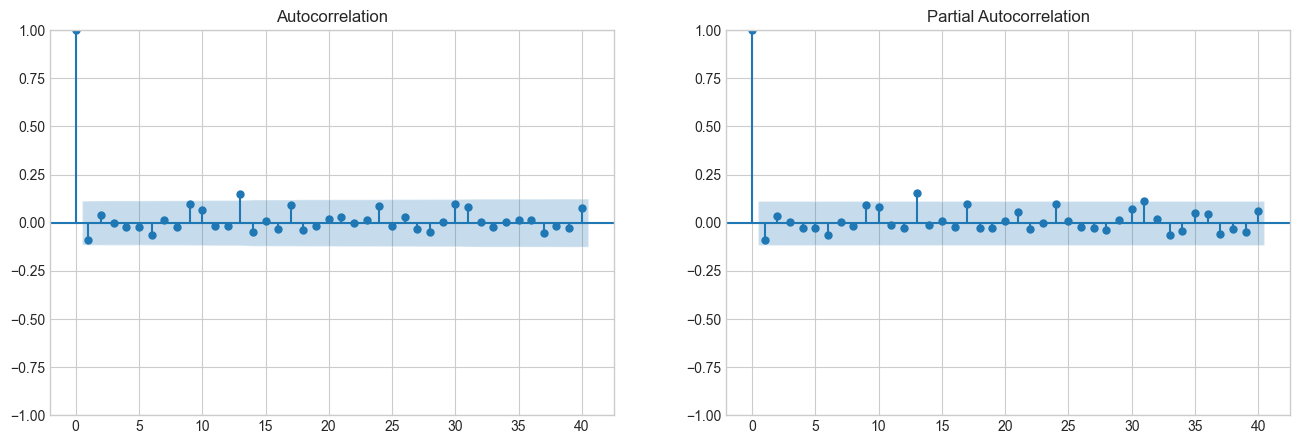

In [10]:
# Cell 9: (Part 3) Stationarity Check and Order Selection (p, d, q)
# Key imports for ARIMA analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# 1. Check stationarity of the target variable to determine 'd'
def check_stationarity(timeseries):
    """Performs the Augmented Dickey-Fuller test."""
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("Conclusion: The series is stationary (d=0).")
        return True, 0
    else:
        print("Conclusion: The series is non-stationary (d=1 is likely needed).")
        return False, 1

is_stationary, d_value = check_stationarity(y_arimax)
data_for_plots = y_arimax.diff().dropna() if not is_stationary else y_arimax

# 2. Plot ACF and PACF to determine 'p' and 'q'
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(data_for_plots, ax=axes[0], lags=40)
plot_pacf(data_for_plots, ax=axes[1], lags=40)
plt.show()

In [11]:
# Cell 10: (Part 3) Fit the ARIMAX Model

# Define the order based on the previous cell's analysis
p, d, q = 1, 1, 1

print(f"Fitting ARIMAX(p={p}, d={d}, q={q}) model with exogenous factors...")

# Instantiate and fit the model, passing the factors to the `exog` parameter
# The model internally handles the differencing for both the endogenous and exogenous variables.
arimax_model = ARIMA(endog=y_arimax, exog=X_arimax_const, order=(p, d, q))
arimax_fitted = arimax_model.fit()

# Print the model summary
print(arimax_fitted.summary())

Fitting ARIMAX(p=1, d=1, q=1) model with exogenous factors...
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  296
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1372.074
Date:                Thu, 31 Jul 2025   AIC                           2758.149
Time:                        13:13:25   BIC                           2783.958
Sample:                    08-31-2024   HQIC                          2768.483
                         - 06-22-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.868e-07   4.93e-05     -0.016      0.987   -9.74e-05    9.58e-05
MKT          438.3746     34.973     12.535      0.000     369.828   

/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


--- Future Factor Scenario ---


,const,MKT,SMB,WML
2025-06-23,1.0,-0.04052,-0.019107,-0.014502
2025-06-24,1.0,-0.04052,-0.019107,-0.014502
2025-06-25,1.0,-0.04052,-0.019107,-0.014502
2025-06-26,1.0,-0.04052,-0.019107,-0.014502
2025-06-27,1.0,-0.04052,-0.019107,-0.014502



Generating forecast...


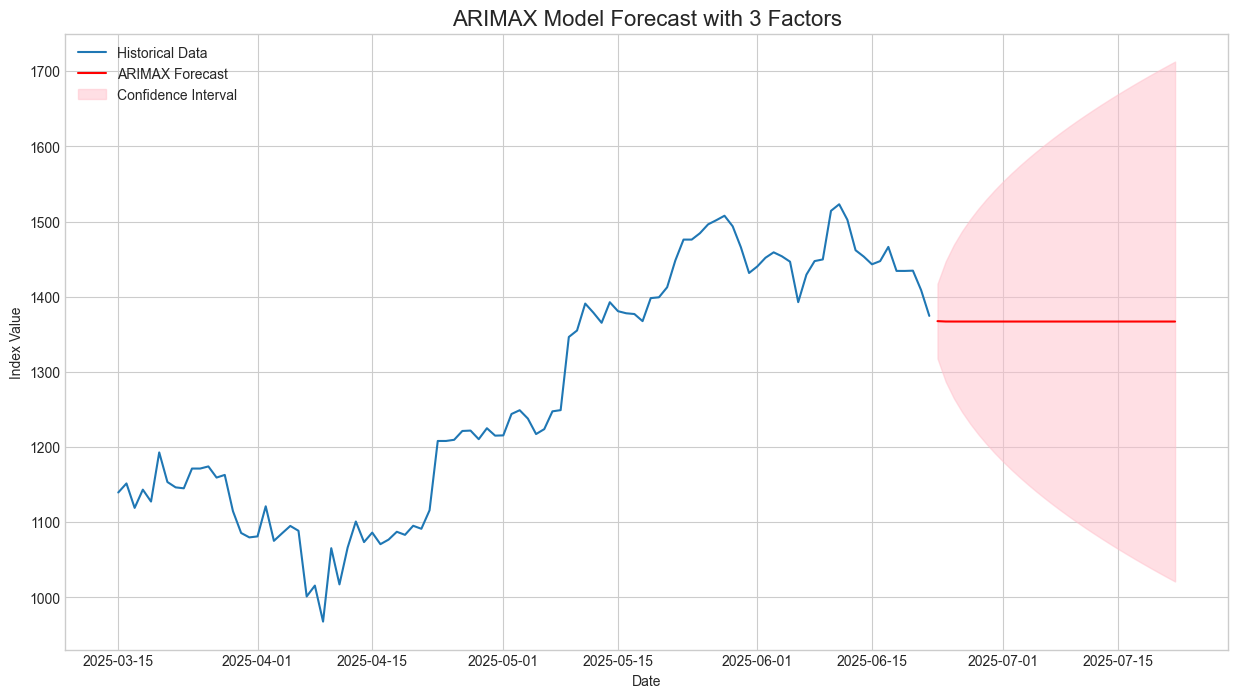

In [12]:
# Cell 11: (Part 3) Forecasting with an ARIMAX Model

# --- Create future scenarios for the exogenous variables ---
n_forecast = 30 # Number of days to forecast
last_date = X_arimax_const.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast)

# Scenario 1: Assume factors hold their last value
last_known_factors = X_arimax_const.iloc[-1]
future_factors = pd.DataFrame([last_known_factors.values]*n_forecast, 
                              index=future_dates, 
                              columns=X_arimax_const.columns)

print("--- Future Factor Scenario ---")
display(future_factors.head())


# --- Generate the forecast ---
print("\nGenerating forecast...")
forecast = arimax_fitted.get_forecast(steps=n_forecast, exog=future_factors)

# Get forecast values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# --- Plot the results ---
plt.figure(figsize=(15, 8))
# Plot historical data (last 100 days for context)
plt.plot(y_arimax.tail(100), label='Historical Data')

# Plot the forecast
plt.plot(forecast_mean, label='ARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='Confidence Interval')

plt.title('ARIMAX Model Forecast with 3 Factors', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.show()

In [13]:
# Cell 12: Introduction and Data Split for Out-of-Sample Testing

print("\n\n--- PART 4: OUT-OF-SAMPLE VALIDATION WITH TRAIN-TEST SPLIT ---")
print("\nHere, we will hold out the last 30 days of data to test the model's real-world forecasting performance.")

# We will use the 'arimax_df' DataFrame created in Cell 8
# If you are running this cell independently, uncomment the lines below to load data
# index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
# features_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
# arimax_df = index_df.join(features_df, how='inner').dropna()
# y_arimax = arimax_df['Value']
# X_arimax_const = sm.add_constant(arimax_df[['MKT', 'SMB', 'HML']])


# --- Create the Train-Test Split ---
# We will train on all data before May 20, 2025, and test on the data after.
split_date = '2025-05-20'
print(f"\nSplitting data into training and testing sets at {split_date}...")

y_train = y_arimax[y_arimax.index <= split_date]
y_test = y_arimax[y_arimax.index > split_date]

X_train = X_arimax_const[X_arimax_const.index <= split_date]
X_test = X_arimax_const[X_arimax_const.index > split_date]

n_test = len(y_test)
print(f"Training set size: {len(y_train)} observations")
print(f"Testing set size:  {n_test} observations")



--- PART 4: OUT-OF-SAMPLE VALIDATION WITH TRAIN-TEST SPLIT ---

Here, we will hold out the last 30 days of data to test the model's real-world forecasting performance.

Splitting data into training and testing sets at 2025-05-20...
Training set size: 263 observations
Testing set size:  33 observations


In [14]:
# Cell 13: (New) Re-Fit the ARIMAX Model on Training Data Only

# The p,d,q order should be determined from the training data's ACF/PACF plots.
# We will proceed with the (1, 1, 1) order we found earlier.
p, d, q = 1, 1, 1

print(f"Fitting ARIMAX(p={p}, d={d}, q={q}) model on the TRAINING data only...")

# Instantiate and fit a new model instance on the training sets
arimax_model_train = ARIMA(endog=y_train, exog=X_train, order=(p, d, q))
arimax_fitted_train = arimax_model_train.fit()

# Print the model summary. Note that this is for the model fitted only on past data.
print(arimax_fitted_train.summary())

Fitting ARIMAX(p=1, d=1, q=1) model on the TRAINING data only...
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1224.978
Date:                Thu, 31 Jul 2025   AIC                           2463.957
Time:                        13:13:26   BIC                           2488.935
Sample:                    08-31-2024   HQIC                          2473.996
                         - 05-20-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.164e-06   9.27e-05     -0.013      0.990      -0.000       0.000
MKT          438.9179     38.483     11.406      0.000     363.493

/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


--- Generating Out-of-Sample Forecast for the Test Period ---


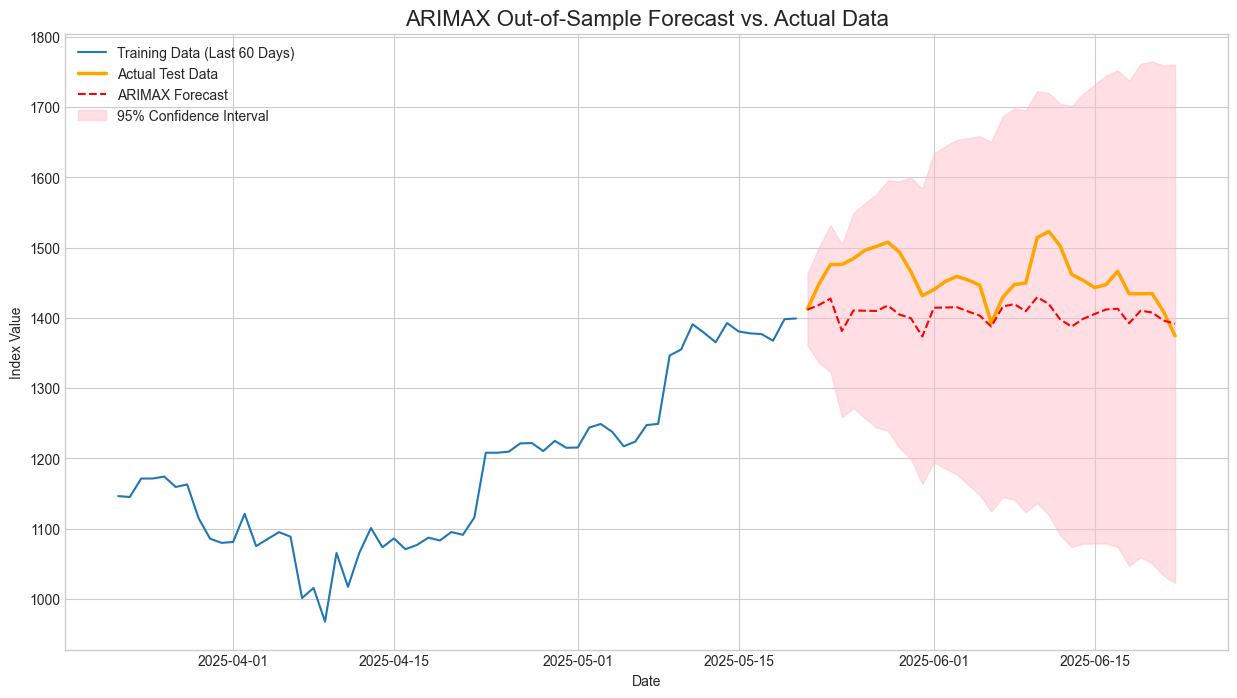


--- Out-of-Sample Forecast Error Metrics ---
Mean Absolute Error (MAE):       50.91
Root Mean Squared Error (RMSE):    58.78
Mean Absolute Percentage Error (MAPE): 3.46%


In [15]:
# Cell 14: (New) Generate and Plot Out-of-Sample Forecast

print("--- Generating Out-of-Sample Forecast for the Test Period ---")

# Use the model trained on historical data to forecast over the test period.
# We MUST provide the exogenous variables for the forecast period (X_test).
forecast = arimax_fitted_train.get_forecast(steps=n_test, exog=X_test)

# Get forecast values and the confidence interval
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# --- Create the Comparison Plot ---
plt.figure(figsize=(15, 8))

# Plot recent historical training data for context
plt.plot(y_train.tail(60), label='Training Data (Last 60 Days)')

# Plot the actual, held-out test data that the model has never seen
plt.plot(y_test, label='Actual Test Data', color='orange', linewidth=2.5)

# Plot the model's forecast for the same test period
plt.plot(forecast_mean, label='ARIMAX Forecast', color='red', linestyle='--')

# Plot the confidence interval around the forecast
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='95% Confidence Interval')

plt.title('ARIMAX Out-of-Sample Forecast vs. Actual Data', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.show()

# --- Calculate Quantitative Error Metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
mape = np.mean(np.abs((y_test - forecast_mean) / y_test)) * 100

print(f"\n--- Out-of-Sample Forecast Error Metrics ---")
print(f"Mean Absolute Error (MAE):       {mae:.2f}")
print(f"Root Mean Squared Error (RMSE):    {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

---
### **Part 4: Checking for Multicollinearity in Factors**

Before finalizing the interpretation of our regression models, it's crucial to check for multicollinearity among our predictor variables (MKT, SMB, and WML). If factors are highly correlated, it can inflate the variance of the coefficient estimates, making them unstable and less reliable. We will use two methods: a correlation matrix and the Variance Inflation Factor (VIF).

--- Checking for Collinearity: Method 1 (Correlation Matrix) ---

Correlation Matrix:


,MKT,SMB,WML
MKT,1.000000,-0.120983,0.524801
SMB,-0.120983,1.000000,0.094625
WML,0.524801,0.094625,1.000000


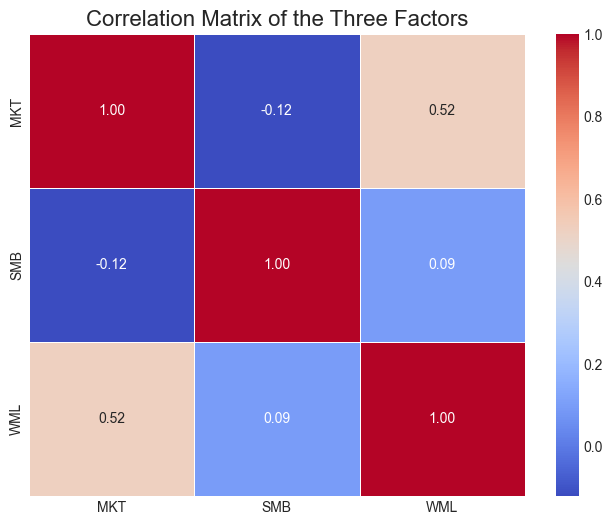


Interpretation:
 - Values close to +1.0 or -1.0 indicate a strong linear relationship.
 - Values close to 0 indicate little to no linear relationship.
 - We are looking for high correlation values (e.g., > 0.7 or < -0.7) between different factors.


In [16]:
# Cell: Method 1 - Correlation Matrix and Heatmap

print("--- Checking for Collinearity: Method 1 (Correlation Matrix) ---")

# We will use the original 3 factors from the 'full_df_orig' DataFrame created in Cell 2
factors_df = full_df_orig[['MKT', 'SMB', 'WML']]

# 1. Calculate the correlation matrix
correlation_matrix = factors_df.corr()

print("\nCorrelation Matrix:")
display(correlation_matrix)

# 2. Visualize the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            annot=True,        # Show the correlation values on the heatmap
            cmap='coolwarm',   # Use a blue-to-red color scheme
            fmt=".2f",         # Format the numbers to two decimal places
            linewidths=.5)
plt.title('Correlation Matrix of the Three Factors', fontsize=16)
plt.show()

print("\nInterpretation:")
print(" - Values close to +1.0 or -1.0 indicate a strong linear relationship.")
print(" - Values close to 0 indicate little to no linear relationship.")
print(" - We are looking for high correlation values (e.g., > 0.7 or < -0.7) between different factors.")


In [17]:
# Cell: Method 2 - Variance Inflation Factor (VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

print("\n--- Checking for Collinearity: Method 2 (Variance Inflation Factor) ---")

# VIF requires a constant to be added to the features
X_vif = add_constant(factors_df)

# Create a DataFrame to hold the VIF results
vif_data = pd.DataFrame()
vif_data["Factor"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\nVariance Inflation Factor (VIF) Results:")
display(vif_data)

print("\nInterpretation:")
print(" - VIF = 1: Not correlated.")
print(" - 1 < VIF < 5: Moderately correlated.")
print(" - VIF > 5 or 10: Highly correlated and a potential cause for concern.")


--- Checking for Collinearity: Method 2 (Variance Inflation Factor) ---

Variance Inflation Factor (VIF) Results:


,Factor,VIF
0,const,1.154462
1,MKT,1.438431
2,SMB,1.051680
3,WML,1.430183



Interpretation:
 - VIF = 1: Not correlated.
 - 1 < VIF < 5: Moderately correlated.
 - VIF > 5 or 10: Highly correlated and a potential cause for concern.




--- Collinearity Analysis of All Engineered Features ---

Calculating correlation matrix for all engineered features...


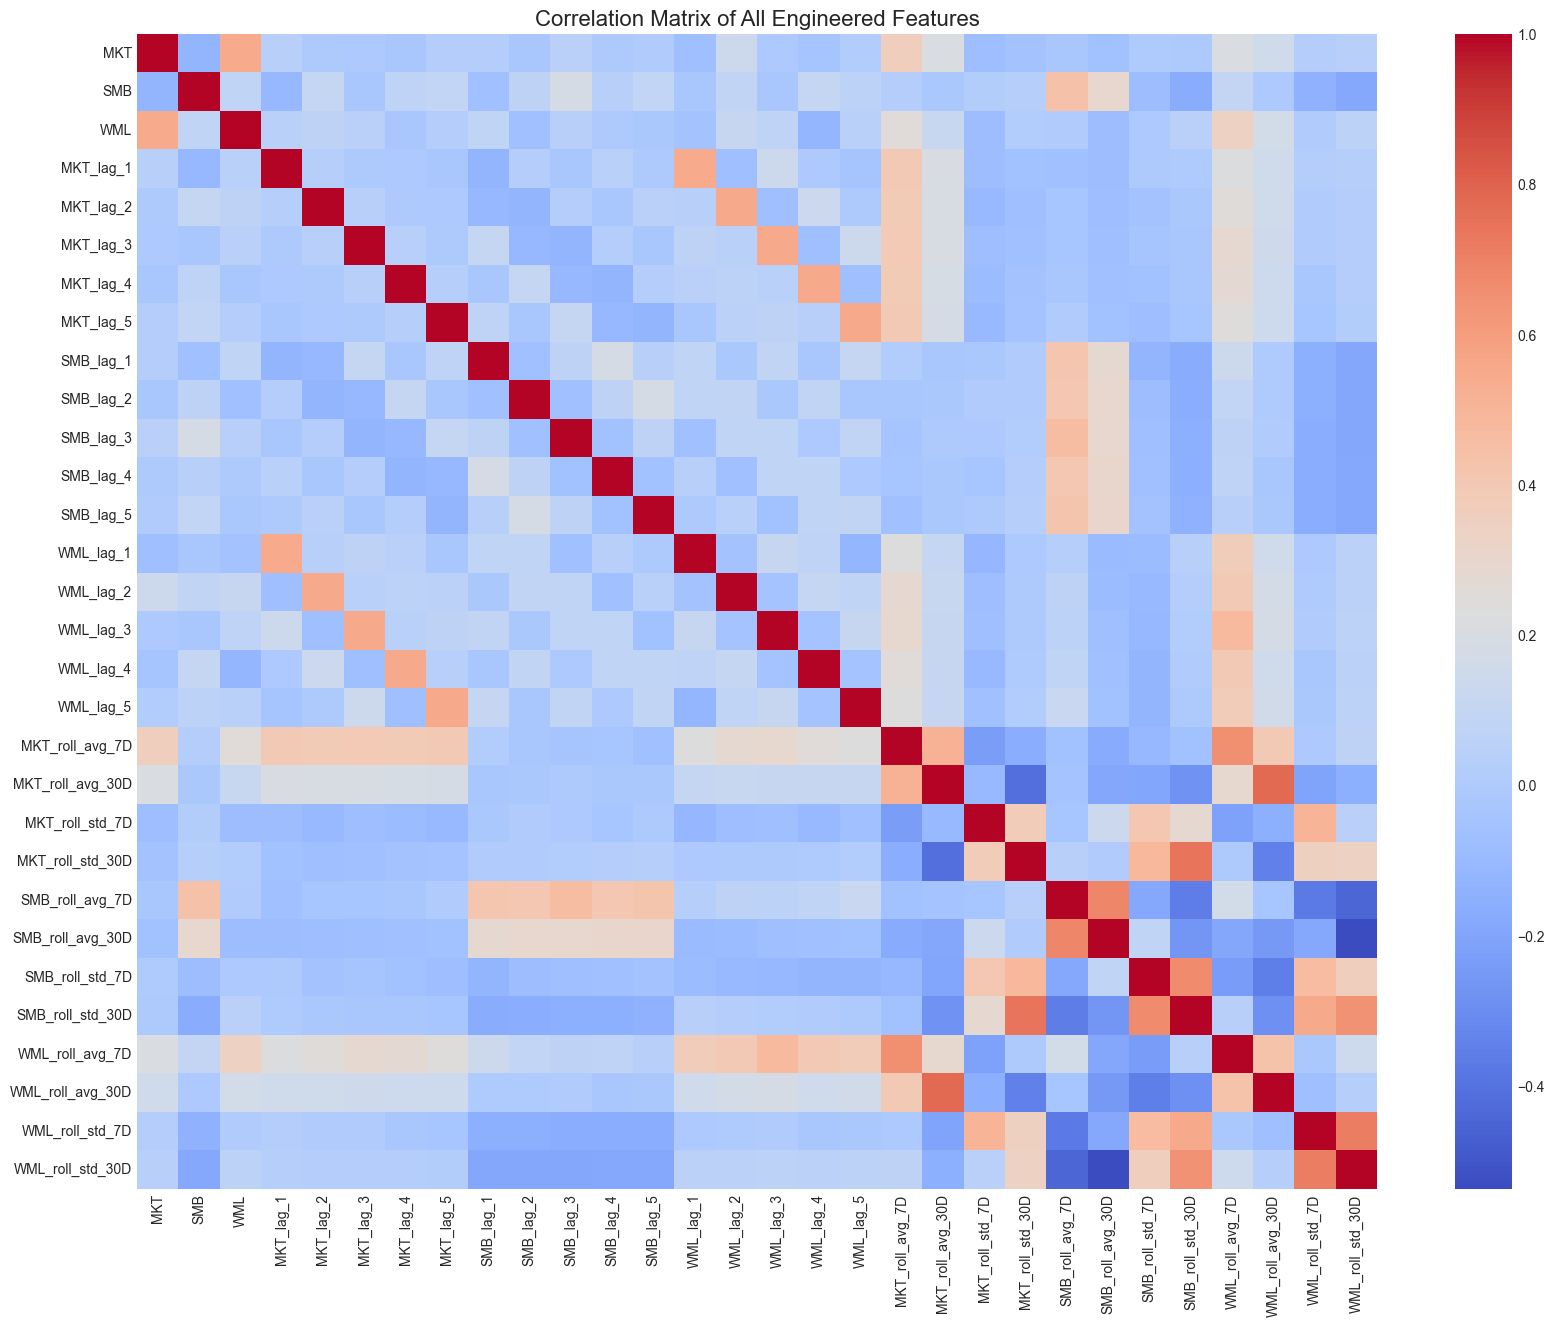


Interpretation:
 - The heatmap will likely show strong blocks of correlation (deep red).
 - This is expected: a factor will be highly correlated with its own lags and rolling averages.

--- Calculating Variance Inflation Factor (VIF) for Engineered Features ---
Note: This may take a moment as it involves many calculations...

Variance Inflation Factor (VIF) Results (Top 15):


,Factor,VIF
0,const,73.975241
27,WML_roll_avg_7D,13.940905
23,SMB_roll_avg_7D,12.878757
19,MKT_roll_avg_7D,12.853848
26,SMB_roll_std_30D,7.949791
30,WML_roll_std_30D,6.533748
20,MKT_roll_avg_30D,5.535363
29,WML_roll_std_7D,5.316776
28,WML_roll_avg_30D,4.726955
22,MKT_roll_std_30D,4.455334



Interpretation:
 - You will almost certainly see many VIF scores well above 10, and some may be extremely large or infinite.
 - This confirms that the engineered feature set has high multicollinearity.
 - This is NOT a reason to discard the features. It is the primary reason why we use regularized models.
   - OLS would fail here (unstable coefficients, huge standard errors).
   - Ridge is specifically designed to handle this by shrinking correlated coefficients.
   - Lasso will handle this by automatically selecting one feature from a highly correlated group and zeroing out the others.


In [18]:
# Cell: Collinearity Analysis of Engineered Features

print("\n\n--- Collinearity Analysis of All Engineered Features ---")

# We will use the 'X_eng' DataFrame created in your notebook
# This contains the original 3 factors plus all lags and rolling stats
# If running independently, load the data first:
# X_eng = pd.read_csv(config.PROCESSED_DATA_DIR / 'engineered_features.csv', index_col='Date', parse_dates=True)

# --- 1. Correlation Matrix and Heatmap ---
print("\nCalculating correlation matrix for all engineered features...")
correlation_matrix_eng = X_eng.corr()

# Visualizing the large correlation matrix can be dense, but a heatmap is still useful
# to spot blocks of high correlation.
plt.figure(figsize=(20, 15)) # Use a larger figure size for readability
sns.heatmap(correlation_matrix_eng, cmap='coolwarm')
plt.title('Correlation Matrix of All Engineered Features', fontsize=16)
plt.show()

print("\nInterpretation:")
print(" - The heatmap will likely show strong blocks of correlation (deep red).")
print(" - This is expected: a factor will be highly correlated with its own lags and rolling averages.")


# --- 2. Variance Inflation Factor (VIF) ---
# VIF is the definitive test here. We expect to see very high VIF scores.
print("\n--- Calculating Variance Inflation Factor (VIF) for Engineered Features ---")
print("Note: This may take a moment as it involves many calculations...")

# VIF requires a constant to be added to the features
X_vif_eng = add_constant(X_eng)

# Create a DataFrame to hold the VIF results
vif_data_eng = pd.DataFrame()
vif_data_eng["Factor"] = X_vif_eng.columns

# Calculate VIF for each feature
vif_values = []
for i in range(X_vif_eng.shape[1]):
    try:
        vif = variance_inflation_factor(X_vif_eng.values, i)
        vif_values.append(vif)
    except Exception as e:
        # This can happen if a feature is perfectly collinear
        vif_values.append(np.inf)
        print(f"Could not calculate VIF for {X_vif_eng.columns[i]}: {e}")

vif_data_eng["VIF"] = vif_values

# Display the VIF results, sorted from highest to lowest
print("\nVariance Inflation Factor (VIF) Results (Top 15):")
display(vif_data_eng.sort_values(by='VIF', ascending=False).head(15))

print("\nInterpretation:")
print(" - You will almost certainly see many VIF scores well above 10, and some may be extremely large or infinite.")
print(" - This confirms that the engineered feature set has high multicollinearity.")
print(" - This is NOT a reason to discard the features. It is the primary reason why we use regularized models.")
print("   - OLS would fail here (unstable coefficients, huge standard errors).")
print("   - Ridge is specifically designed to handle this by shrinking correlated coefficients.")
print("   - Lasso will handle this by automatically selecting one feature from a highly correlated group and zeroing out the others.")

---
### **Part 5: Comparative Analysis - PCA Index vs. Total Market Capitalization**

To validate the uniqueness and explanatory power of the PCA-based index, we will now conduct a comparative analysis. In this section, we will replace our PCA index with a traditional benchmark—the **total market capitalization** of all assets—and use it as the response variable. By fitting the same five models with the same three factors, we can directly compare the R-squared values to determine which "market" representation is better explained by the common risk factors.

In [19]:
# Cell: Prepare Data for Market Cap Analysis

print("--- Preparing Data for Market Cap as Response Variable ---")

# 1. Load the factors and the full market cap data
try:
    factors_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    # Use the full_data_cache which has market caps for all assets
    market_cap_data = pd.read_csv(config.MARKET_CAP_FILE_PATH, index_col='Date', parse_dates=True)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")

# 2. Calculate the total market capitalization for each day
total_market_cap = market_cap_data.sum(axis=1)

# 3. Create the analysis DataFrame
mcap_analysis_df = pd.DataFrame(total_market_cap, columns=['Total_Market_Cap']).join(factors_df, how='inner')

# 4. Calculate log returns for the total market cap (our new 'y')
mcap_analysis_df['mcap_return'] = np.log(mcap_analysis_df['Total_Market_Cap']).diff()

# 5. Get risk-free rate and calculate excess returns
rf_rate = get_risk_free_rate(mcap_analysis_df.index.min(), mcap_analysis_df.index.max())
mcap_analysis_df['rf_rate'] = rf_rate['DTB3'].reindex(mcap_analysis_df.index, method='ffill').fillna(0)
mcap_analysis_df['mcap_excess_return'] = mcap_analysis_df['mcap_return'] - mcap_analysis_df['rf_rate']

mcap_analysis_df.dropna(inplace=True)

# 6. Define X, y, and scaled X
X_mcap = mcap_analysis_df[['MKT', 'SMB', 'WML']]
y_mcap = mcap_analysis_df['mcap_excess_return']

scaler_mcap = StandardScaler()
X_mcap_scaled = scaler_mcap.fit_transform(X_mcap)

print("Data for Market Cap analysis is prepared.")

--- Preparing Data for Market Cap as Response Variable ---
Data loaded successfully.
Data for Market Cap analysis is prepared.


In [20]:
# Cell: Train All 5 Models on Market Cap Data

print("\n--- Training all 5 models with Total Market Cap as the response variable ---")
# We use the same TimeSeriesSplit strategy for fair comparison
# tscv = TimeSeriesSplit(n_splits=5) was defined in a previous cell

# 1. Statsmodels OLS
X_sm_mcap = sm.add_constant(X_mcap)
sm_results_mcap = sm.OLS(y_mcap, X_sm_mcap).fit()

# 2. RidgeCV
ridge_cv_mcap = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=tscv).fit(X_mcap_scaled, y_mcap)

# 3. LassoCV
lasso_cv_mcap = LassoCV(alphas=np.logspace(-6, 2, 100), cv=tscv, random_state=42).fit(X_mcap_scaled, y_mcap)

# 4. Random Forest
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
rf_grid_mcap = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_mcap, y_mcap)

# 5. XGBoost
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}
xgb_grid_mcap = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), xgb_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_mcap, y_mcap)

print("All models for the Market Cap analysis have been trained.")


--- Training all 5 models with Total Market Cap as the response variable ---
All models for the Market Cap analysis have been trained.


In [21]:
# Cell: Display and Compare Results

print("\n--- RESULTS FOR MODELS ON TOTAL MARKET CAP ---")

# --- OLS Coefficients & P-Values ---
mcap_coeffs_df = pd.DataFrame({
    'Coefficient': sm_results_mcap.params,
    'P-Value': sm_results_mcap.pvalues
}).rename(index={'const': 'Intercept'})
print("\n--- OLS Coefficients & P-Values (for Total Market Cap) ---")
display(mcap_coeffs_df)

# --- Model Performance Comparison ---
mcap_results_data = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Market Cap R-squared': [
        sm_results_mcap.rsquared_adj,
        r2_score(y_mcap, ridge_cv_mcap.predict(X_mcap_scaled)),
        r2_score(y_mcap, lasso_cv_mcap.predict(X_mcap_scaled)),
        rf_grid_mcap.best_score_,
        xgb_grid_mcap.best_score_
    ]
}
mcap_results_df = pd.DataFrame(mcap_results_data)
print("\n--- Model Performance on Total Market Cap ---")
display(mcap_results_df)

# --- FINAL COMPARISON ---
# Display the original PCA Index results again for easy comparison
print("\n--- For Comparison: Model Performance on PCA Index (from Part 1) ---")
display(results_df_orig) # Assumes results_df_orig from Cell 4 is still in memory

print("\n\n--- How to Interpret the Comparison ---")
print("Compare the 'Market Cap R-squared' table above with the 'PCA Index R-squared' table.")
print("  - If the R-squared values for your PCA Index are CONSISTENTLY HIGHER, it suggests your index captures the risk factors more effectively than the simple total market cap.")
print("  - If the R-squared values for the Total Market Cap are HIGHER, it suggests that the simple market cap weighted index is better explained by the factors.")
print("  - Look at the OLS coefficients: Are the factor sensitivities (betas) different for your index compared to the total market cap? This reveals differences in their risk profiles.")


--- RESULTS FOR MODELS ON TOTAL MARKET CAP ---

--- OLS Coefficients & P-Values (for Total Market Cap) ---


,Coefficient,P-Value
Intercept,0.001757,6.091263e-03
MKT,0.709941,2.598593e-102
SMB,-0.048782,5.316714e-02
WML,-0.009910,7.762675e-01



--- Model Performance on Total Market Cap ---


,Model,Market Cap R-squared
0,OLS,0.843579
1,Ridge,0.845154
2,Lasso,0.843889
3,Random Forest,0.755636
4,XGBoost,0.725280



--- For Comparison: Model Performance on PCA Index (from Part 1) ---


,Model,Out-of-Sample R-squared
0,OLS,0.713078
1,Ridge,0.715935
2,Lasso,0.715168
3,Random Forest,0.565759
4,XGBoost,0.500157




--- How to Interpret the Comparison ---
Compare the 'Market Cap R-squared' table above with the 'PCA Index R-squared' table.
  - If the R-squared values for your PCA Index are CONSISTENTLY HIGHER, it suggests your index captures the risk factors more effectively than the simple total market cap.
  - If the R-squared values for the Total Market Cap are HIGHER, it suggests that the simple market cap weighted index is better explained by the factors.
  - Look at the OLS coefficients: Are the factor sensitivities (betas) different for your index compared to the total market cap? This reveals differences in their risk profiles.


In [22]:
# Cell (Final): Consolidated R-squared Comparison Table

print("\n\n--- FINAL SHOWDOWN: PCA Index vs. Total Market Cap ---")

# --- Step 1: Re-gather all R-squared results to ensure they are correct ---

# Gather results for models trained on the PCA Index
pca_index_results_data = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'PCA Index R-squared': [
        sm_results_orig.rsquared_adj, # From Cell 3
        r2_score(y_orig, ridge_cv_orig.predict(X_orig_scaled)), # From Cell 3
        r2_score(y_orig, lasso_cv_orig.predict(X_orig_scaled)), # From Cell 3
        rf_grid_orig.best_score_, # From Cell 3
        xgb_grid_orig.best_score_ # From Cell 3
    ]
}
pca_results_df = pd.DataFrame(pca_index_results_data)


# Gather results for models trained on the Total Market Cap
market_cap_results_data = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Market Cap R-squared': [
        sm_results_mcap.rsquared_adj, # From the Market Cap analysis cell
        r2_score(y_mcap, ridge_cv_mcap.predict(X_mcap_scaled)), # From the Market Cap analysis cell
        r2_score(y_mcap, lasso_cv_mcap.predict(X_mcap_scaled)), # From the Market Cap analysis cell
        rf_grid_mcap.best_score_, # From the Market Cap analysis cell
        xgb_grid_mcap.best_score_ # From the Market Cap analysis cell
    ]
}
mcap_results_df = pd.DataFrame(market_cap_results_data)

# --- Step 2: Merge the two results DataFrames into a final comparison table ---
comparison_df = pd.merge(pca_results_df, mcap_results_df, on='Model')

# Set 'Model' as the index for a cleaner display
comparison_df.set_index('Model', inplace=True)

# --- Step 3: Display the final formatted table ---
print("\n--- Comparative Model Performance ---")
display(comparison_df.style.format({
    'PCA Index R-squared': '{:.4f}',
    'Market Cap R-squared': '{:.4f}'
}).background_gradient(cmap='viridis'))


print("\n\n--- Final Interpretation Guide ---")
print("This table directly compares the explanatory power of the three-factor model on your PCA index versus the total market capitalization.")
print("\n- For each row (each model), which R-squared value is higher?")
print("  - If 'PCA Index R-squared' is consistently higher, it provides strong evidence that your index construction methodology captures the underlying risk factors more cleanly and effectively than a simple market-cap sum.")
print("  - If 'Market Cap R-squared' is higher, it suggests that the raw market cap is more sensitive to the MKT, SMB, and HML factors.")
print("\n- Which single cell in the table has the highest value? This identifies the best-performing model and target combination overall.")



--- FINAL SHOWDOWN: PCA Index vs. Total Market Cap ---

--- Comparative Model Performance ---


,PCA Index R-squared,Market Cap R-squared
Model,,
OLS,0.7131,0.8436
Ridge,0.7159,0.8452
Lasso,0.7152,0.8439
Random Forest,0.5658,0.7556
XGBoost,0.5002,0.7253




--- Final Interpretation Guide ---
This table directly compares the explanatory power of the three-factor model on your PCA index versus the total market capitalization.

- For each row (each model), which R-squared value is higher?
  - If 'PCA Index R-squared' is consistently higher, it provides strong evidence that your index construction methodology captures the underlying risk factors more cleanly and effectively than a simple market-cap sum.
  - If 'Market Cap R-squared' is higher, it suggests that the raw market cap is more sensitive to the MKT, SMB, and HML factors.

- Which single cell in the table has the highest value? This identifies the best-performing model and target combination overall.


In [23]:
print("\n--- OLS Coefficients & P-Values (for Total Market Cap) ---")
display(mcap_coeffs_df)
print("\n--- Linear Model Coefficients & P-Values (for PCA-Index) ---")
display(coeffs_df)


--- OLS Coefficients & P-Values (for Total Market Cap) ---


,Coefficient,P-Value
Intercept,0.001757,6.091263e-03
MKT,0.709941,2.598593e-102
SMB,-0.048782,5.316714e-02
WML,-0.009910,7.762675e-01



--- Linear Model Coefficients & P-Values (for PCA-Index) ---


,OLS Coefficient,P-Value,Ridge Coefficient (Scaled),Lasso Coefficient (Scaled)
Intercept,0.002006,2.752700e-02,-,-
MKT,0.664125,3.388248e-63,0.021778,0.021638
SMB,-0.005266,8.832264e-01,-0.000171,-0.0
WML,0.068173,1.688487e-01,0.001523,0.00092


In [64]:
comparison_df

,PCA Index R-squared,Market Cap R-squared
Model,,
OLS,0.713078,0.843579
Ridge,0.715935,0.845154
Lasso,0.715168,0.843889
Random Forest,0.565759,0.755636
XGBoost,0.500157,0.725280


In [65]:
print("--- PART 1: ANALYSIS WITH ORIGINAL 3 FACTORS (new index) ---")
print("\nLoading data...")

try:
    features_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    index_df = pd.read_csv("../data/processed/dynamic_pca_index_new.csv", index_col='Date', parse_dates=True)
    print("Original 3-factor dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")

# Prepare data for regression
full_df_orig = index_df.join(features_df, how='inner')
full_df_orig['pca_return'] = np.log(full_df_orig['Value']).diff()
rf_rate = get_risk_free_rate(full_df_orig.index.min(), full_df_orig.index.max())
full_df_orig['rf_rate'] = rf_rate['DTB3'].reindex(full_df_orig.index, method='ffill').fillna(0)
full_df_orig['pca_excess_return'] = full_df_orig['pca_return'] - full_df_orig['rf_rate']
full_df_orig.dropna(inplace=True)

# Define X, y and the CV strategy
X_orig = full_df_orig[['MKT', 'SMB', 'WML']]
y_orig = full_df_orig['pca_excess_return']
tscv = TimeSeriesSplit(n_splits=5)

# Scale features for relevant models
scaler_orig = StandardScaler()
X_orig_scaled = scaler_orig.fit_transform(X_orig)

print("Data for Part 1 is prepared.")

--- PART 1: ANALYSIS WITH ORIGINAL 3 FACTORS (new index) ---

Loading data...
Original 3-factor dataset loaded successfully.
Data for Part 1 is prepared.


In [66]:
print("Training all 5 models on the original 3-factor dataset...")

# 1. Statsmodels OLS (for p-values)
X_sm_orig = sm.add_constant(X_orig)
sm_results_orig = sm.OLS(y_orig, X_sm_orig).fit()

# 2. RidgeCV
ridge_cv_orig = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=tscv).fit(X_orig_scaled, y_orig)

# 3. LassoCV
lasso_cv_orig = LassoCV(alphas=np.logspace(-6, 2, 100), cv=tscv, random_state=42).fit(X_orig_scaled, y_orig)

# 4. Random Forest
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10]}
rf_grid_orig = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_orig, y_orig)
best_rf_orig = rf_grid_orig.best_estimator_

# 5. XGBoost
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}
xgb_grid_orig = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), xgb_param_grid, cv=tscv, scoring='r2', n_jobs=-1).fit(X_orig, y_orig)
best_xgb_orig = xgb_grid_orig.best_estimator_

print("All models for Part 1 have been trained.")

Training all 5 models on the original 3-factor dataset...
All models for Part 1 have been trained.


In [67]:
# Cell 4: (Part 1) Display Results

print("--- RESULTS FOR ORIGINAL 3-FACTOR MODELS ---")

# --- 1. Coefficients for Linear Models ---
# Note: OLS coeffs are from unscaled data for direct interpretation.
# Ridge/Lasso coeffs are from scaled data, showing shrinkage.
coeffs_df = pd.DataFrame({
    'OLS Coefficient': sm_results_orig.params,
    'P-Value': sm_results_orig.pvalues
}).rename(index={'const': 'Intercept'})

# Add scaled coefficients for Ridge and Lasso
coeffs_df['Ridge Coefficient (Scaled)'] = pd.Series(ridge_cv_orig.coef_, index=X_orig.columns)
coeffs_df['Lasso Coefficient (Scaled)'] = pd.Series(lasso_cv_orig.coef_, index=X_orig.columns)
coeffs_df.fillna('-', inplace=True)

print("\n--- Linear Model Coefficients & P-Values ---")
display(coeffs_df)


# --- 2. Feature Importances for Tree-Based Models ---
# For these models, "importance" is the equivalent of a coefficient's magnitude.
importances_df = pd.DataFrame({
    'Random Forest Importance': best_rf_orig.feature_importances_,
    'XGBoost Importance': best_xgb_orig.feature_importances_
}, index=X_orig.columns).sort_values(by='XGBoost Importance', ascending=False)

print("\n--- Tree-Based Model Feature Importances ---")
display(importances_df)


# --- 3. Model Performance Comparison ---
results_data = {
    'Model': ['OLS', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Out-of-Sample R-squared': [
        sm_results_orig.rsquared_adj,
        r2_score(y_orig, ridge_cv_orig.predict(X_orig_scaled)),
        r2_score(y_orig, lasso_cv_orig.predict(X_orig_scaled)),
        rf_grid_orig.best_score_,
        xgb_grid_orig.best_score_
    ]
}
results_df_orig = pd.DataFrame(results_data)
print("\n--- Overall Model Performance on 3 Factors ---")
display(results_df_orig)

--- RESULTS FOR ORIGINAL 3-FACTOR MODELS ---

--- Linear Model Coefficients & P-Values ---


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_8805/1673563601.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  coeffs_df.fillna('-', inplace=True)


,OLS Coefficient,P-Value,Ridge Coefficient (Scaled),Lasso Coefficient (Scaled)
Intercept,0.002006,2.825222e-02,-,-
MKT,0.643308,2.343213e-60,0.021094,0.020874
SMB,-0.008394,8.157622e-01,-0.000245,-0.0
WML,0.051990,2.960214e-01,0.001192,0.000484



--- Tree-Based Model Feature Importances ---


,Random Forest Importance,XGBoost Importance
MKT,0.879397,0.818219
WML,0.075379,0.099940
SMB,0.045223,0.081842



--- Overall Model Performance on 3 Factors ---


,Model,Out-of-Sample R-squared
0,OLS,0.694864
1,Ridge,0.697907
2,Lasso,0.696672
3,Random Forest,0.545777
4,XGBoost,0.478936


--- Training LSTM with MKT, SMB, and HML Factors ---
Data loaded successfully.

Building and training the LSTM model...


/Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model training complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

Out-of-Sample R-squared from LSTM: -0.1482


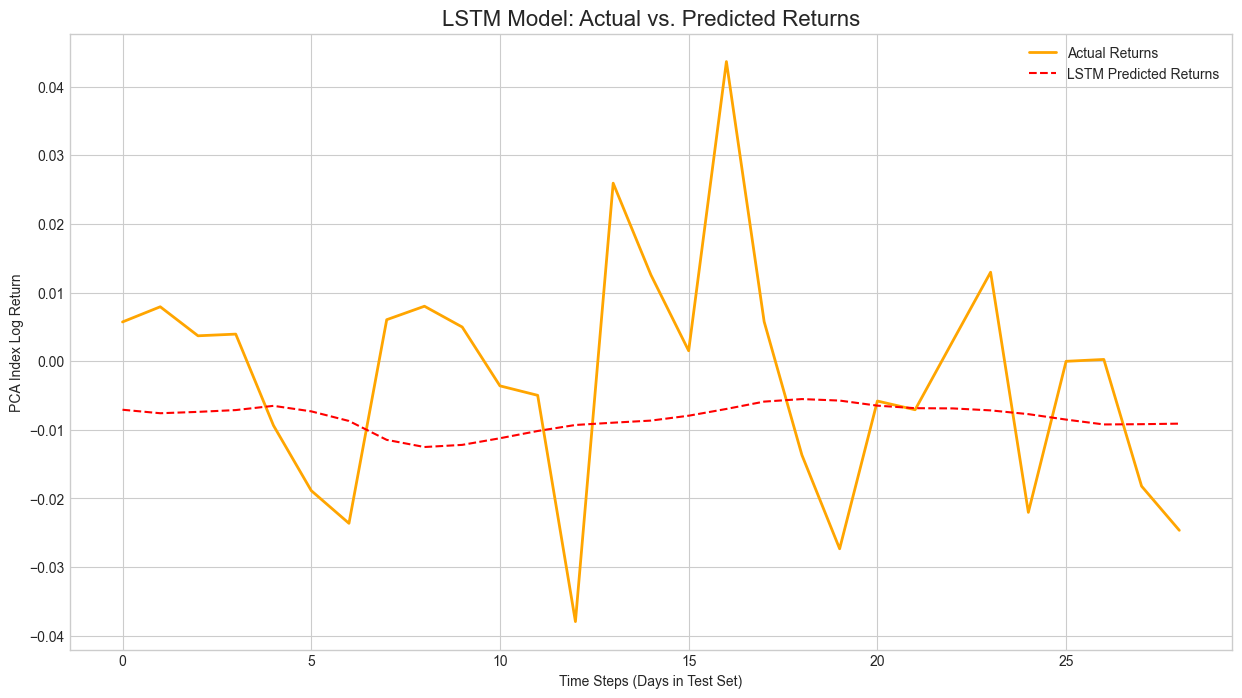

In [68]:
# Cell: LSTM Model with 3 Factors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import config

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

print("--- Training LSTM with MKT, SMB, and HML Factors ---")

# --- 1. Load and Prepare Data ---
try:
    # Load the PCA index and the 3 factors
    index_df = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    factors_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please run calculation scripts first. Missing: {e.filename}")
    # Stop execution if a file is missing
    assert False, "Required data file not found."

# Combine into a single DataFrame and calculate log returns for the index
full_df = index_df.join(factors_df, how='inner')
full_df['pca_return'] = np.log(full_df['Value']).diff()
full_df.dropna(inplace=True)

# Define our features (X) and target (y)
X = full_df[['MKT', 'SMB', 'WML']].values
y = full_df[['pca_return']].values # Keep as 2D array for the scaler

# --- 2. Scale and Split Data ---
# LSTMs are sensitive to scale. We scale features and target separately.
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a train-test split (e.g., first 80% for training)
training_data_len = int(np.ceil(len(X_scaled) * 0.8))
train_X, train_y = X_scaled[:training_data_len], y_scaled[:training_data_len]
test_X, test_y = X_scaled[training_data_len:], y_scaled[training_data_len:]

# --- 3. Create Time-Series Sequences ---
# We'll use the last 30 days of factors to predict the next day's return.
def create_sequences(X_data, y_data, time_steps=30):
    Xs, ys = [], []
    for i in range(time_steps, len(X_data)):
        Xs.append(X_data[i-time_steps:i, :]) # Get 30 days of factors
        ys.append(y_data[i, 0])              # Get the corresponding return
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train_seq, y_train_seq = create_sequences(train_X, train_y, time_steps)
X_test_seq, y_test_seq = create_sequences(test_X, test_y, time_steps)

# --- 4. Build and Train the LSTM Model ---
print("\nBuilding and training the LSTM model...")
model = Sequential([
    # Input shape is (time_steps, num_features)
    LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=20, validation_split=0.1, verbose=0)
print("Model training complete.")

# --- 5. Make Predictions and Evaluate ---
predictions_scaled = model.predict(X_test_seq)
# We must use the 'y' scaler to transform the predictions back to the original scale
predictions = scaler_y.inverse_transform(predictions_scaled)

# Also, un-scale the actual test data for comparison
y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

# Calculate R-squared score
r2 = r2_score(y_test_actual, predictions)
print(f"\nOut-of-Sample R-squared from LSTM: {r2:.4f}")

# --- 6. Plot the Results ---
plt.figure(figsize=(15, 8))
plt.plot(y_test_actual, label='Actual Returns', color='orange', linewidth=2)
plt.plot(predictions, label='LSTM Predicted Returns', color='red', linestyle='--')
plt.title('LSTM Model: Actual vs. Predicted Returns', fontsize=16)
plt.xlabel('Time Steps (Days in Test Set)')
plt.ylabel('PCA Index Log Return')
plt.legend()
plt.show()

---
### **Part 7: Comparative Regression Analysis (BGCI vs. PCA Index)**

In this final analysis, we will directly compare the performance of our two constructed indices: the BGCI-style index and the dynamic PCA index. We will run the same OLS three-factor regression on both and compare their R-squared values and factor sensitivities (betas) to determine which methodology produces an index that is more effectively explained by the common crypto risk factors.

In [69]:
# Cell: Prepare Data for Comparative Regression

print("--- Preparing Data for BGCI vs. PCA Index Regression ---")

# 1. Load the factors and both index data files
try:
    factors_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    pca_index = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    bgci_index = pd.read_csv(config.PROCESSED_DATA_DIR / 'bgci_style_index.csv', index_col='Date', parse_dates=True)
    print("All necessary data files loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please ensure all index calculation scripts have been run. Missing: {e.filename}")
    # Stop execution if a file is missing
    assert False, "Required data file not found."

# 2. Combine and prepare the data
# Merge all dataframes on their common dates
comparison_df = pd.concat([pca_index.rename(columns={'Value': 'PCA_Index'}),
                           bgci_index,
                           factors_df], axis=1).dropna()

# 3. Calculate log returns for both indices
comparison_df['pca_return'] = np.log(comparison_df['PCA_Index']).diff()
comparison_df['bgci_return'] = np.log(comparison_df['BGCI_Style_Index']).diff()

# 4. Get risk-free rate and calculate excess returns for both
rf_rate = get_risk_free_rate(comparison_df.index.min(), comparison_df.index.max())
comparison_df['rf_rate'] = rf_rate['DTB3'].reindex(comparison_df.index, method='ffill').fillna(0)

comparison_df['pca_excess_return'] = comparison_df['pca_return'] - comparison_df['rf_rate']
comparison_df['bgci_excess_return'] = comparison_df['bgci_return'] - comparison_df['rf_rate']
comparison_df.dropna(inplace=True)

# 5. Define the common independent variables (X) and the two dependent variables (y)
X_factors = sm.add_constant(comparison_df[['MKT', 'SMB', 'WML']])
y_pca = comparison_df['pca_excess_return']
y_bgci = comparison_df['bgci_excess_return']

print("Data preparation complete.")

--- Preparing Data for BGCI vs. PCA Index Regression ---
All necessary data files loaded successfully.
Data preparation complete.


In [70]:
# Cell: Fit OLS Models for Both Indices

print("--- Fitting OLS Models ---")

# 1. Fit OLS model for the PCA Index
model_pca = sm.OLS(y_pca, X_factors)
results_pca = model_pca.fit()
print("OLS model for PCA Index fitted.")

# 2. Fit OLS model for the BGCI-Style Index
model_bgci = sm.OLS(y_bgci, X_factors)
results_bgci = model_bgci.fit()
print("OLS model for BGCI-Style Index fitted.")

--- Fitting OLS Models ---
OLS model for PCA Index fitted.
OLS model for BGCI-Style Index fitted.


In [71]:
# Cell: OLS Regression Comparison (PCA Index vs. BGCI-Style Index)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from src import config # Assuming you are in the notebooks directory

print("--- OLS Regression Comparison: PCA vs. BGCI ---")

# --- 1. Load the necessary data files ---
try:
    factors_df = pd.read_csv(config.THREE_FACTOR_FILE_PATH, index_col='Date', parse_dates=True)
    pca_index = pd.read_csv(config.INDEX_FILE_PATH, index_col='Date', parse_dates=True)
    bgci_index = pd.read_csv(config.PROCESSED_DATA_DIR / 'bgci_style_index.csv', index_col='Date', parse_dates=True)
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please ensure all index calculation scripts have been run. Missing: {e.filename}")
    # Stop execution if a file is missing
    assert False, "Required data file not found."

# --- 2. Prepare Data for Regression ---
# Merge all dataframes on their common dates
comparison_df = pd.concat([
    pca_index.rename(columns={'Value': 'PCA_Index'}),
    bgci_index,
    factors_df
], axis=1).dropna()

# Calculate log returns for both indices
comparison_df['pca_return'] = np.log(comparison_df['PCA_Index']).diff()
comparison_df['bgci_return'] = np.log(comparison_df['BGCI_Style_Index']).diff()

# Get risk-free rate and calculate excess returns for both
rf_rate = get_risk_free_rate(comparison_df.index.min(), comparison_df.index.max())
comparison_df['rf_rate'] = rf_rate['DTB3'].reindex(comparison_df.index, method='ffill').fillna(0)
comparison_df['pca_excess_return'] = comparison_df['pca_return'] - comparison_df['rf_rate']
comparison_df['bgci_excess_return'] = comparison_df['bgci_return'] - comparison_df['rf_rate']
comparison_df.dropna(inplace=True)

# Define the common independent variables (X) and the two dependent variables (y)
X_factors = sm.add_constant(comparison_df[['MKT', 'SMB', 'WML']]) # Using HML to match your report
y_pca = comparison_df['pca_excess_return']
y_bgci = comparison_df['bgci_excess_return']

# --- 3. Fit OLS Models for Both Indices ---
print("\nFitting OLS models...")
# Fit OLS model for the PCA Index
results_pca = sm.OLS(y_pca, X_factors).fit()
print("OLS model for PCA Index fitted.")

# Fit OLS model for the BGCI-Style Index
results_bgci = sm.OLS(y_bgci, X_factors).fit()
print("OLS model for BGCI-Style Index fitted.")

# --- 4. Create and Display the Comparison Table ---
print("\n--- OLS Regression Results: PCA Index vs. BGCI-Style Index ---")

# Create a DataFrame for the comparison
results_comparison_df = pd.DataFrame({
    'PCA_Index_Coeff': results_pca.params,
    'PCA_Index_PValue': results_pca.pvalues,
    'BGCI_Index_Coeff': results_bgci.params,
    'BGCI_Index_PValue': results_bgci.pvalues
}).rename(index={'const': 'Intercept'})

# Add the Adjusted R-squared values for an overall comparison
rsquared_summary = pd.DataFrame({
    'PCA_Index_Coeff': [results_pca.rsquared_adj],
    'PCA_Index_PValue': ['-'],
    'BGCI_Index_Coeff': [results_bgci.rsquared_adj],
    'BGCI_Index_PValue': ['-']
}, index=['Adj. R-squared'])

final_table = pd.concat([results_comparison_df, rsquared_summary])

print(final_table)

--- OLS Regression Comparison: PCA vs. BGCI ---
All data files loaded successfully.

Fitting OLS models...
OLS model for PCA Index fitted.
OLS model for BGCI-Style Index fitted.

--- OLS Regression Results: PCA Index vs. BGCI-Style Index ---
                PCA_Index_Coeff PCA_Index_PValue  BGCI_Index_Coeff  \
Intercept              0.002006         0.027527          0.001942   
MKT                    0.664125              0.0          0.687883   
SMB                   -0.005266         0.883226         -0.035607   
WML                    0.068173         0.168849          0.001910   
Adj. R-squared         0.713078                -          0.819806   

               BGCI_Index_PValue  
Intercept               0.004279  
MKT                          0.0  
SMB                     0.183021  
WML                     0.958658  
Adj. R-squared                 -  
